# üß† Time Series Classification with XGBoost on FordA Dataset

This project demonstrates how to apply **XGBoost** for binary classification of univariate time series data using the **FordA dataset**. The dataset records engine noise and the goal is to classify whether an engine has a problem (`1`) or not (`-1`). We'll load the data, preprocess it, train an XGBoost model, and evaluate its performance.


## üìÇ Data Loading

In [20]:
# Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn and XGBoost tools
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Libraries for progress tracking and timing
from tqdm import tqdm
import time

In [21]:
# Download FordA training and test files from Google Drive
# Download FordA_TRAIN.tsv
!gdown 1ZJkoYmYBjUEcTPnW00gMfiJ9cTltb-II

# Download FordA_TEST.tsv
!gdown 1PPZ0IPpVIWymL1tf0YEud2fuJGK-0FVI

Downloading...
From: https://drive.google.com/uc?id=1ZJkoYmYBjUEcTPnW00gMfiJ9cTltb-II
To: e:\AIO2024\AIO2024_Projects\Module_3\XGBoost_Time_Series_Classification\FordA_TEST.tsv

  0%|          | 0.00/7.36M [00:00<?, ?B/s]
  7%|‚ñã         | 524k/7.36M [00:00<00:02, 3.12MB/s]
 21%|‚ñà‚ñà‚ñè       | 1.57M/7.36M [00:00<00:00, 6.42MB/s]
 36%|‚ñà‚ñà‚ñà‚ñå      | 2.62M/7.36M [00:01<00:02, 2.30MB/s]
 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 3.67M/7.36M [00:01<00:01, 3.17MB/s]
 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 4.72M/7.36M [00:01<00:00, 3.96MB/s]
 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 5.77M/7.36M [00:01<00:00, 4.69MB/s]
 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 6.82M/7.36M [00:01<00:00, 5.12MB/s]
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7.36M/7.36M [00:01<00:00, 4.30MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PPZ0IPpVIWymL1tf0YEud2fuJGK-0FVI
To: e:\AIO2024\AIO2024_Projects\Module_3\XGBoost_Time_Series_Classification\FordA_TRAIN.tsv

  0%|          | 0.00/20.1M [00:00<?, ?B/s]
  3%|‚ñé         | 524k/20.1M [00:00

In [22]:
# Define a function to read UCR time series files
def read_ucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]        # First column is the label
    x = data[:, 1:]       # Remaining columns are features
    return x, y.astype(int)

In [23]:
# Load train and test data
x_train, y_train = read_ucr("FordA_TRAIN.tsv")
x_test, y_test = read_ucr("FordA_TEST.tsv")

## üîç Data Exploring & Preprocessing

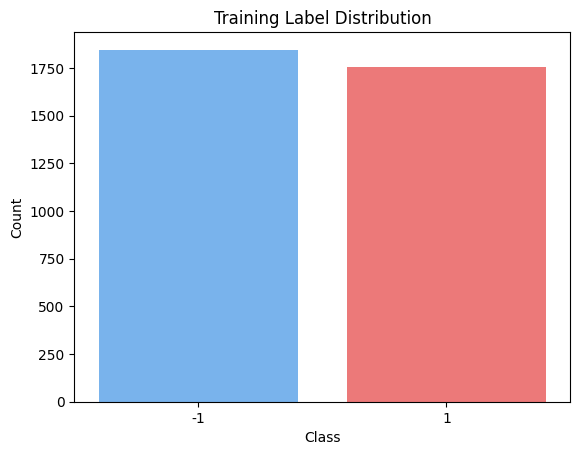

In [24]:
# Visualize label distribution
sns.countplot(x=y_train, hue=y_train, palette={-1: "#66b3ff", 1: "#ff6666"}, legend=False)
plt.title("Training Label Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

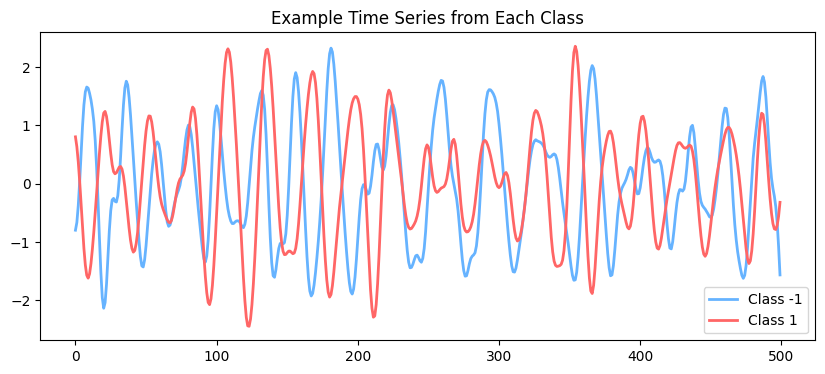

In [25]:
# Plot one example time series from each class
classes = np.unique(np.concatenate((y_train, y_test)))
plt.figure(figsize=(10, 4))
colors = {-1: "#66b3ff", 1: "#ff6666"}
for c in classes:
    sample = x_train[y_train == c][0]
    plt.plot(sample, label=f"Class {c}", color=colors[c], alpha=1, linewidth=2)
plt.legend(loc="best")
plt.title("Example Time Series from Each Class")
plt.show()

In [26]:
# Feature scaling (StandardScaler)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

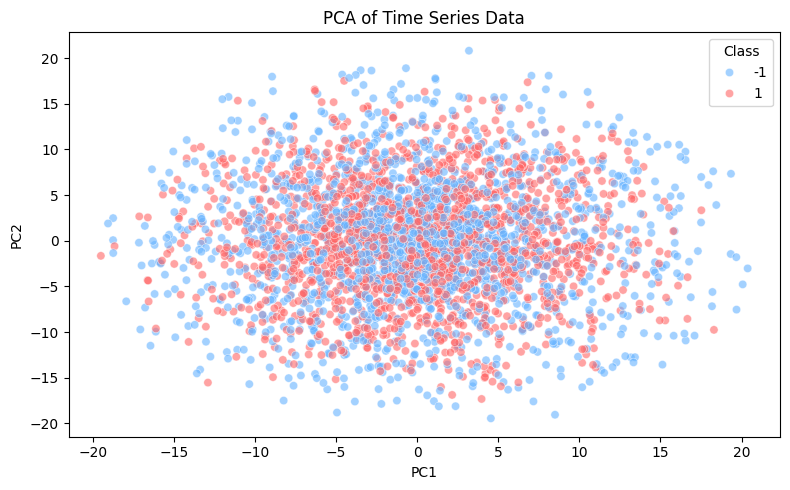

In [27]:
# Reduce to 2D for visualization
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=x_train_pca[:, 0], y=x_train_pca[:, 1], hue=y_train, palette={-1: "#66b3ff", 1: "#ff6666"}, alpha=0.6)
plt.title("PCA of Time Series Data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Class")
plt.tight_layout()
plt.show()

## üöÄ Training XGBoost Model

In [28]:
# Convert labels from -1 to 0 for binary classification
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

# Initialize and train the XGBoost classifier
xgb_model = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, subsample=0.8, 
                          colsample_bytree=0.8, eval_metric='logloss', random_state=42)
xgb_model.fit(x_train, y_train)

# Generate predictions
y_pred = xgb_model.predict(x_test)

## üìä Evaluating XGBoost Model

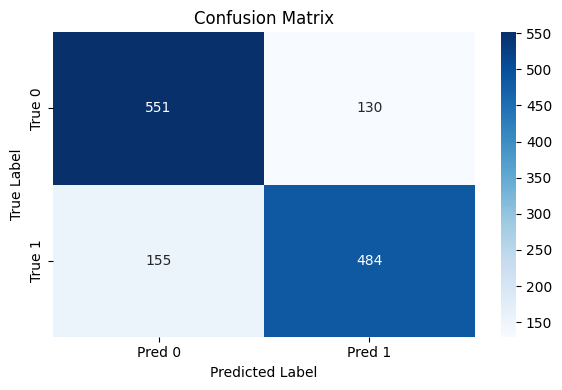

In [29]:
# Confusion Matrix 
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


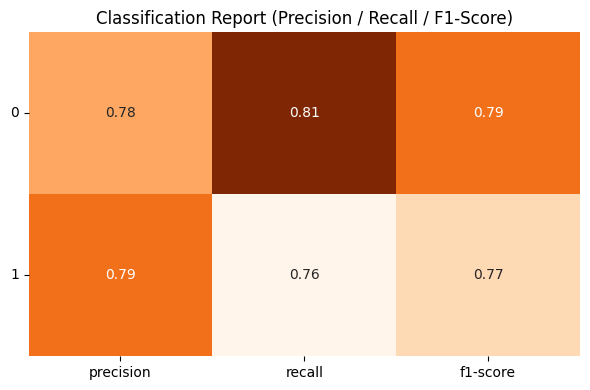

In [30]:
# Classification Report
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df[["precision", "recall", "f1-score"]].round(2)

# Plot classification report as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(report_df.iloc[:2], annot=True, cmap="Oranges", cbar=False)
plt.title("Classification Report (Precision / Recall / F1-Score)")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


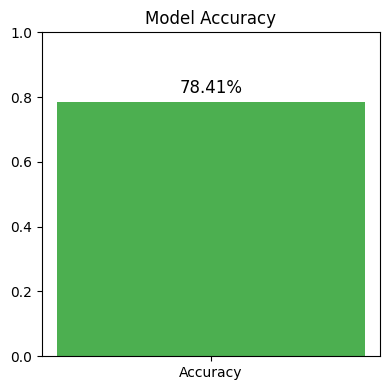

In [31]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Plot accuracy as a bar chart
plt.figure(figsize=(4, 4))
plt.bar(["Accuracy"], [accuracy], color="#4CAF50")
plt.ylim(0, 1)
plt.text(0, accuracy + 0.03, f"{accuracy:.2%}", ha='center', fontsize=12)
plt.title("Model Accuracy")
plt.tight_layout()
plt.show()


## ‚öñÔ∏è Performance Comparison of XGBoost and Other Models Using K-Fold Cross-Validation

In [32]:
# Define and evaluate multiple models
models = {
    "XGBoost": XGBClassifier(
        n_estimators=200, max_depth=5, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8,
        eval_metric='logloss', random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, max_depth=10, min_samples_split=5,
        min_samples_leaf=2, max_features='sqrt',
        random_state=42
    ),
    "KNN": KNeighborsClassifier(
        n_neighbors=5, weights='distance', metric='euclidean'
    ),
    "SVM": SVC(
        kernel='rbf', C=1.0, gamma='scale', probability=True
    ),
    "Logistic Regression": LogisticRegression(
        solver='liblinear', C=1.0, penalty='l2', random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42
    ),
    "AdaBoost": AdaBoostClassifier(
        n_estimators=200, learning_rate=0.5, random_state=42
    ),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(100,), max_iter=300, alpha=0.01, random_state=42
    )
}

# Define 5-fold Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [33]:
# Loop through models
model_scores = {}
for name, model in tqdm(models.items(), desc="üîÑ Cross-validating models"):
    print(f"\n‚è≥ Cross-validating: {name}")
    start_time = time.time()

    # Evaluate model using cross_val_score
    scores = cross_val_score(
        model, x_train, y_train,
        cv=cv,
        scoring=make_scorer(accuracy_score)
    )

    # Store scores
    model_scores[name] = scores

    # Calculate duration
    end_time = time.time()
    duration = end_time - start_time

    print(f"‚úÖ {name} | Mean Accuracy: {scores.mean():.4f} ¬± {scores.std():.4f} | Time: {duration:.2f}s")


üîÑ Cross-validating models:   0%|          | 0/8 [00:00<?, ?it/s]


‚è≥ Cross-validating: XGBoost


üîÑ Cross-validating models:  12%|‚ñà‚ñé        | 1/8 [00:23<02:41, 23.04s/it]

‚úÖ XGBoost | Mean Accuracy: 0.7737 ¬± 0.0143 | Time: 23.04s

‚è≥ Cross-validating: Random Forest


üîÑ Cross-validating models:  25%|‚ñà‚ñà‚ñå       | 2/8 [01:26<04:41, 46.96s/it]

‚úÖ Random Forest | Mean Accuracy: 0.7459 ¬± 0.0169 | Time: 63.71s

‚è≥ Cross-validating: KNN


üîÑ Cross-validating models:  38%|‚ñà‚ñà‚ñà‚ñä      | 3/8 [01:27<02:08, 25.64s/it]

‚úÖ KNN | Mean Accuracy: 0.6987 ¬± 0.0150 | Time: 0.27s

‚è≥ Cross-validating: SVM


üîÑ Cross-validating models:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 4/8 [02:09<02:09, 32.44s/it]

‚úÖ SVM | Mean Accuracy: 0.8098 ¬± 0.0121 | Time: 42.85s

‚è≥ Cross-validating: Logistic Regression


üîÑ Cross-validating models:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 5/8 [02:22<01:16, 25.47s/it]

‚úÖ Logistic Regression | Mean Accuracy: 0.5015 ¬± 0.0145 | Time: 13.09s

‚è≥ Cross-validating: Gradient Boosting


üîÑ Cross-validating models:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 6/8 [22:34<14:17, 428.66s/it]

‚úÖ Gradient Boosting | Mean Accuracy: 0.7248 ¬± 0.0179 | Time: 1211.33s

‚è≥ Cross-validating: AdaBoost


üîÑ Cross-validating models:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 7/8 [27:28<06:24, 384.73s/it]

‚úÖ AdaBoost | Mean Accuracy: 0.5004 ¬± 0.0161 | Time: 294.30s

‚è≥ Cross-validating: MLP


üîÑ Cross-validating models: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8/8 [28:02<00:00, 210.30s/it]

‚úÖ MLP | Mean Accuracy: 0.8048 ¬± 0.0176 | Time: 33.81s


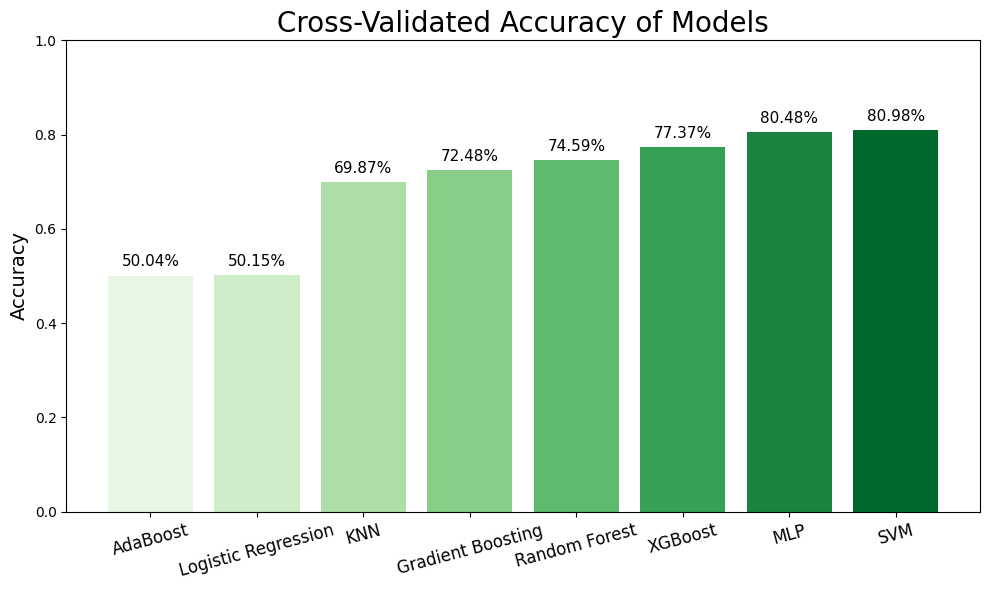

In [36]:
# Sorted model scores by mean accuracy
sorted_scores = sorted(model_scores.items(), key=lambda x: x[1].mean())
model_names, accuracies = zip(*[(name, scores.mean()) for name, scores in sorted_scores])

# Use modern gradient color
colors = sns.color_palette("Greens", len(accuracies))

# Plot bar chart using matplotlib for full control
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=colors)

# Annotate accuracy on top
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, acc + 0.02, f"{acc:.2%}",
             ha='center', fontsize=11)

# Customize appearance
plt.title("Cross-Validated Accuracy of Models", fontsize=20)
plt.ylabel("Accuracy", fontsize=14)
plt.ylim(0, 1.0)
plt.xticks(rotation=15, fontsize=12)
plt.tight_layout()
plt.show()
